# TTV Project

Identification des génotypes de *torque teno virus* présents chez les donneurs et receveurs de greffe <br>
[OVERVIEW](https://docs.google.com/presentation/d/1ddYZr6uFXvWhx2wVmzzJ6F3a97x3xI6KONeIiZdLdm0/edit?usp=sharing)

## 0) Bulk ideas / TODO

- Do plots (camemberts avec != cutoffs, 100, 1000...) <br>
- Brainstorming about assembly step. <br>
- Tools to try : <br>
https://sourceforge.net/projects/sb2nhri/files/drVM/ <br>
http://ivory.idyll.org/blog/2017-classify-genome-bins-with-custom-db-try-again.html <br>
https://www.biorxiv.org/content/early/2017/10/02/196998 <br>


Obtenir un compte non-biaisé du nombre de reads par génotypes de TTV.

Estimer le pourcentage de reads humains, bactériens, fongiques et viraux.

Identifier la ou les souches de TTV qui sont transmises du donneur au receveur et la ou les souches de TTV qui expliquent la majeur partie de la charge virale.

Qui des "multi best-hits" <=> sur 2 génome différents avec de bon scores ? -> Discard ?

Puce 1 = Dorian = Manuel, Puce 2 = Dorian = library-builder, Puce 3 = GenoLim, 3.33 = Manuel, 3.63 = library-builder.

Le biais de hit envers Orf1 s'expliquerai-t-il par multi best-hit d'un même hit sur Orf1 et sur une autre zone chez les TTV (en supposant que ce soit majoritairement l'autre zone qui ait un meilleur score et qui soit donc sélectionnée). Ou alors pour une raison bio-mol qui m'échappe, plus faible qualité des reads qui span majoritairement sur Orf1, du coup ils auraient en grande partie sauté lors du trimming ?

L'estimation de la charge virale a été faite avant le rolling circle (nous avons les chiffres, estimée via les 128 nts en 5' via primer de Dorian) et après (manque les chiffres) -> need them.

Cinétique des G (poster vu par Sophie) -> % de chaque G // charge vir ? G et apparition/disparition.

Plots : Faire un volet génomes complets et en regard un volet avec les autres génomes.

Filter : Etape actuelles vs vir_DB ne serviraient qu'a choper des reads candidats qu'on re-blasterai avec des params bcp + spécifiques contre les TTV ensuite ?

X) L'analyse comportera 2 "embranchements" : <br>
- Chemin Orf1 || génomes_complets
- Puis raisonnement sur génotypes pris 1 à 1 || groupes phylo de génotypes. <br>
Ps : Pour voir si on s'attend à une grande différence entre Orf1 & complet, plot par génotypes le pileup des reads (des hits) sur séquences génome complet de l'étude. <br>

A) Décrire les génotypes de TTV présents chez les D & R (D_all, R_all, R_35, R_75, R_360). <br>

B) Des génotypes de TTV sont-ils transmis de D vers R, si oui quels sont-ils (Ps : Sachant que la charge virale est faible ches les D, si un génotype est présent chez D, alors on doit le rechercher chez tous les R) ? Certains ne sont-ils jamais transmis ? Taux de transmission ? Taux / succès de transmission est-il lié à la charge virale du D ? <br>

C) Quels sont les génotypes qui croissent ou décroissent chez les R (quel(s) G(s) explique(nt) la plus grande partie de l'augmentation de la charge virale) ? Viennent-ils de D ? Sont-ce les mêmes 2/3 génotypes / groupe phylo de génotypes qui croissent chez tout les R ? (doit-on rapporter à la charge virale ?) <br>

D) Les génotypes trouvés chez D & R sont-ils les mêmes d'un point de vue séquence ? Ex : D transmet G18 à R. G18 subit-il des modifs chez R ? (need assembly or something here => tool publi gigascience ?). Ps : Check aussi si recombinaison entre Gx & Gy (check via reads chevauchants ?). Un point important ici va être de donner la bonne sélection de reads en entrée d'un éventuel assemblage (donner filtered -Bact -Fungus ? Quid de refiltrer sur les no-match?). Et selon ce qu'on arrive à assembler, il faut prendre à peu près la même séquence pour comparer ensuite (genre si on assemble 3 G complet et 7 Orf1, prendre 10 Orf1 pour les comparaisons). <br>

Exploratoire) "Top 10" des familles / espèces / ... les plus fréquentes lors du blastn vs Viral, Fungal & Bacterial. Pour max X reads qui ne se sont alignés contre rien, blast vs nt / nr.

## 1) Introduction <a name="introduction_1"></a>
Ces dernières années, le séquençage haut débit a permis d'identifier de nouveaux virus chez l'Homme, dont le torque teno virus (TTV). Le TTV est l'espèce majoritaire au sein de la famille des Annelovirus, qui est la famille principale de virus associés à l'Homme. Le TTV n'est pour le moment pas directement associé à une maladie, mais son abondance est corrélée à certains phénomènes (abondance +++ chez les immunodéprimés). Le génome du TTV est à ADN simple brin circulaire, d'environ 3,8 Kb. Il est pour le moment classé en 5 génogroupes contenant 29 génotypes.

Chez les patients qui reçoivent une greffe, il existe une état dit "optimal d'immunosupression", qui correspond à une charge virale qui minimise à la fois le risque de rejet et le risque d'infection opportuniste (Figure 1). Une des hypothèse de ce projet est que que la charge en TTV représente un bon marqueur de la charge virale et donc de l'état d'immunosupression.

##### Figure 1 : Charge en TTV et immunosupression (adapté de De Vlaminck, Cell, 2013)

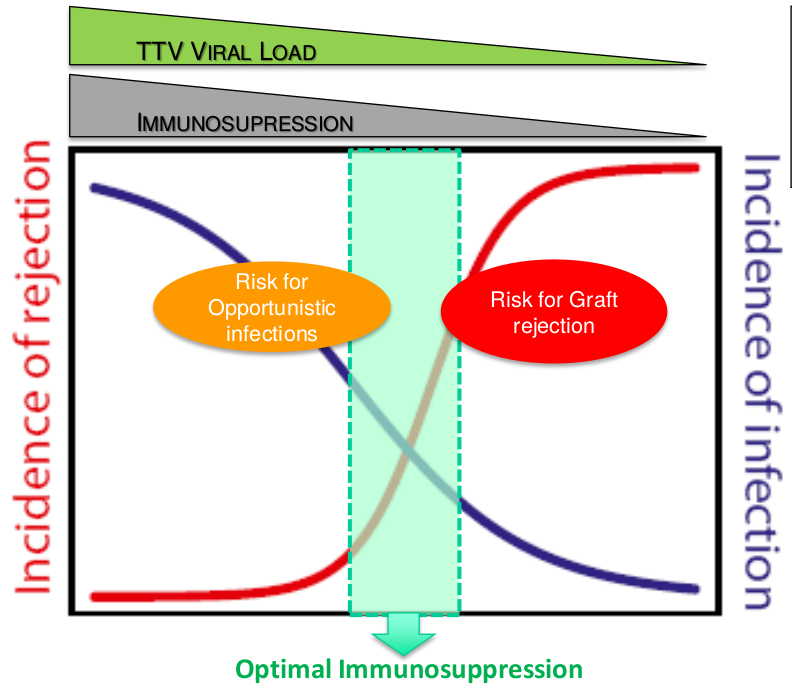

In [1]:
### CODE ###
display < ./Picture/optimal_immunosuppression.png;

## 2) Data

20 couples de donneur-receveur de greffes (pour lesquels le kit TTV est positif). Pour chaque donneur, 1 échantillon de sang ou plasma est prélevé 1 jour avant le don. Pour le receveur associé, de 1 à 3 échantillons de sang ou plasma sont prélevés à différentes intervalles de temps après la greffe (35, 75 ou 360 jours après transplantation). L'ADN de chaque échantillon est extrait (via un procédé de Rolling Circle Amplification qui cible les particules de type virales (donc biaise la capture d'ARN en faveur des particules de type virales)) puis séquencé sur Ion Proton (GénoLim - Limoges). Au total 66 échantillons (20 de donneurs et 46 de receveurs(20 à J35, 19 à J75 et 7 à J360)) sont fournis à la cellule bioinformatique. La correspondance entre les données brutes de séquençages et entre les échantillons biologiques est renseignée dans ce [tableur](https://docs.google.com/spreadsheets/d/1KI94IUmesq1CZwdfSobA2qzEM8ZeqHWh8sR3QPar_K0/edit?usp=sharing). La correspondance fut déduite à partir de ~/Desktop/TTV/BISCEm/Docs/corresp_D-R_barecode_16062017.ppt &
~/Desktop/TTV/BISCEm/Docs/donneurs_receveurs.xlsx.

### 2.1) Raw reads

106 FASTA files coming from 3 differents Ion Proton runs (GénoLim). <br>

In [ ]:
### CODE ###
display < ./Picture/raw.png;

Number of reads in raw files :

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Data/Reads_raw;
for f in *fastq.gz;
do lines=$(zgrep -Ec "$" $f);
   printf $f;
   printf '\t'$(($lines/4))'\n';
done &>> temp.tsv;
sed -i '1 i\Sample\tRead_count' temp.tsv;
(head -1 temp.tsv && sort -nr -k2 <(tail -n +2 temp.tsv)) | csvlook;
rm temp.tsv;

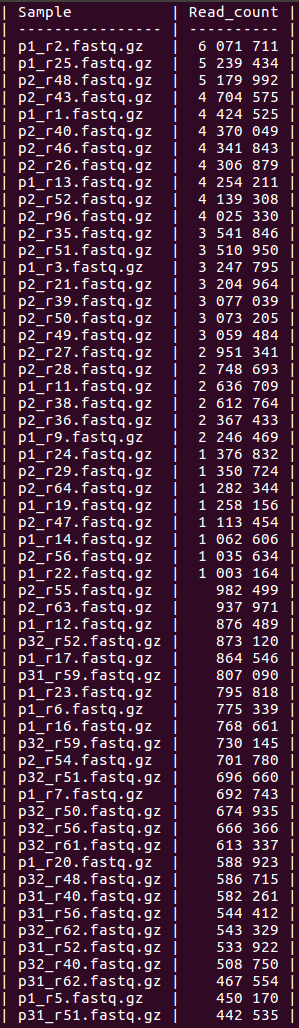

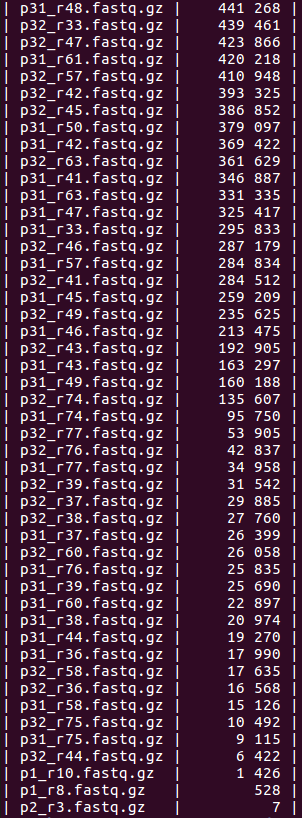

In [2]:
### CODE ###
display < ./Picture/read_count_1.png;
display < ./Picture/read_count_2.png;

### 2.2) Human genome

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Data/Human;
axel ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/\
GCA_000001405.26_GRCh38.p11/GCA_000001405.26_GRCh38.p11_genomic.fna.gz;
md5sum GCA_000001405.26_GRCh38.p11_genomic.fna.gz; # f48d3166ede36c3381643dace60348b9

### 2.3) TTV genotypes

Retrieval sources :

- NCBI taxonomy (29) : ID = 687331 <=> Alphatorquevirus : <br>
Don't take those listed as "simian". <br>
Manually retrieve them, then cat into > ~/Desktop/TTV/BISCEm/Data/TTV/ncbi_taxid_687331_ttv_20170622.fasta <br>


- Reference genome (1) : <br>
https://www.ncbi.nlm.nih.gov/nuccore/NC_015783.1 > ~/Desktop/TTV/BISCEm/Data/TTV/ncbi_ttv_ref_genome_20170622.fasta.gz <br>


- Via entrez search terms (27) : <br>
https://ncbiinsights.ncbi.nlm.nih.gov/2013/02/19/how-to-download-bacterial-genomes-using-the-entrez-api <br> https://www.ncbi.nlm.nih.gov/books/NBK179288

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Data/TTV;

# Retrieve TTV ID (!= taxo)
wget -O ttv_genome.xml "https://eutils.ncbi.nlm.nih.gov/entrez/\
eutils/esearch.fcgi?db=genome&term=torque+teno+virus";
id=$(grep -oP '<Id>\K.*?(?=<\/Id>)' ttv_genome.xml);

# Use this ID to get all TTV genomes IDs from nuccore database
wget -O ttv_genomes_ids.xml "https://eutils.ncbi.nlm.nih.gov/entrez\
/eutils/elink.fcgi?dbfrom=genome&db=nuccore&id=$id";
grep -oP '<Id>\K.*?(?=<\/Id>)' ttv_genomes_ids.xml > ttv_genomes_ids.txt;
sed -i '1d' ttv_genomes_ids.txt;

# Filter out genomes IDs not associated with H.sapiens, then retrieve associated FASTA sequences
while read line;
do wget -O temp.txt "https://eutils.ncbi.nlm.nih.gov/entrez/\
eutils/efetch.fcgi?db=nuccore&id=$line&retmode=text"; 
   if grep --quiet "sapiens" temp.txt;
   then echo $line >> ttv_genomes_ids_with_hsapiens.txt;
   fi;
done < ttv_genomes_ids.txt;
while read line;
do wget -O - "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/\
efetch.fcgi?db=nuccore&id=$line&rettype=fasta&retmode=text" >> entrez_ttv_genomes_with_hsapiens_20170622.fasta;
done < ttv_genomes_ids_with_hsapiens.txt;
pigz entrez_ttv_genomes_with_hsapiens_20170622.fasta;

# Clean all these temp files mess
rm ttv_genome.xml ttv_genomes_ids.xml ttv_genomes_ids.txt temp.txt ttv_genomes_ids_with_hsapiens.txt;

Then cat those 3 files in a single FASTA file (containing the 57 genotypes) :

In [ ]:
### CODE ###
cat ncbi_taxid_687331_ttv_20170622.fasta.gz \
    ncbi_ttv_ref_genome_20170622.fasta.gz \
    entrez_ttv_genomes_with_hsapiens_20170622.fasta.gz > all_ttv_genotypes.fasta.gz;

### 2.4) Microbial databases

##### ncbi_refseq_release vs ncbi_genome_refseq

For viral & fungal DBs, we have the option to chose between ncbi_refseq_release "RR" and ncbi_genome_refseq "GR". <br>
Below we try to understand which one to pick, using a viral DB exameple :

In [ ]:
### CODE ###
# RR
wget ftp://ftp.ncbi.nlm.nih.gov/refseq/release/viral/*.genomic.fna.gz;
cat *.fna.gz > ncbi_refseq_release_viral.fna.gz;
rm -f !(ncbi_refseq_release_viral.fna.gz);

# GR
curl 'ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/viral/assembly_summary.txt' \
| awk '{FS="\t"} !/^#/ {print $20}' \
| sed -r 's|(ftp://ftp.ncbi.nlm.nih.gov/genomes/all/.+/)(GCF_.+)|\1\2/\2_genomic.fna.gz|' \
> list_viral.txt;
sed -i 's/ftp:\/\//rsync:\/\//g' list_viral.txt;
while read line;
do rsync --quiet --times $line .;
done < list_viral.txt;
cat *.fna.gz > ncbi_genome_refseq_viral.fna.gz;
rm -f !(ncbi_genome_refseq_viral.fna.gz);

# Investigate difference between RR & GR
zcat ncbi_refseq_release_viral.fna.gz | awk '/^>/ {print $1}' > ids_rr.txt;
sed -i 's/>ref//g' ids_rr.txt;
sed -i 's/|//g' ids_rr.txt;
sort -u -o ids_rr.txt ids_rr.txt;
zcat ncbi_genome_refseq_viral.fna.gz | awk '/^>/ {print $1}' > ids_gr.txt;
sed -i 's/>//g' ids_gr.txt;
sort -u -o ids_gr.txt ids_gr.txt;
comm ids_rr.txt ids_gr.txt > comm_viral_RR_vs_GR.tsv;
printf "unique to rr :\t"; awk -F "\t" '{if($1 != "") print $1}' comm_viral_RR_vs_GR.tsv | wc -l;
printf "unique to gr :\t"; awk -F "\t" '{if($2 != "") print $2}' comm_viral_RR_vs_GR.tsv | wc -l;
printf "common to both :\t"; awk -F "\t" '{if($3 != "") print $3}' comm_viral_RR_vs_GR.tsv | wc -l;

218 are unique to RR <br>
2 are unique to GR <br>
9116 are common <br>
The 2 seqs unique to GR are NC_025349.2 & NC_027348.1 <br>
But they also exist in RR as NC_025349.3 & NC_027348.2 (more up-to-date versions) <br>
Thus, use RR as it contains more stuff & up-to-date.

#### 2.4.1) Viral

In [ ]:
### CODE ###
wget ftp://ftp.ncbi.nlm.nih.gov/refseq/release/viral/*.genomic.fna.gz;
cat *.fna.gz > ncbi_refseq_release_viral.fna.gz;
rm -f !(ncbi_refseq_release_viral.fna.gz);

#### 2.4.2) Fungal

In [ ]:
### CODE ###
wget ftp://ftp.ncbi.nlm.nih.gov/refseq/release/fungi/*.genomic.fna.gz;
cat *.fna.gz > ncbi_refseq_release_fungi.fna.gz;
rm -f !(ncbi_refseq_release_fungi.fna.gz);

#### 2.4.3) Bacterial

Given that the NCBI refseq contain too much sequences (100+ Go) for the future blastn step to be done in a reasonable amount of computing time, we needed to reduce the size of the bacterial database. The choice was made to use The Human microbiome project (HMP) as a ressource. <br>
In 2009, HMP compiled a database of microbial reference genomes (HMREFG), as described here : http://www.hmpdacc.org/HMREFG. This database contains archea, low-eucaryote, viral & bacterial, which are reported in the fasta header as follow : >ARCH, >EUKY, >VIRL, >BACT. The bacterial component of this database underwent a process of removing highly redundant, non HMP-sequenced reference genomes.

In [ ]:
### CODE ###
# Retrieve the HMREFG file, decompress & rename it
cd ~/Desktop/TTV/BISCEm/Data/Bacterial;
axel -q ftp://public-ftp.hmpdacc.org/HMREFG/all_seqs.fa.bz2;
bzip2 -d all_seqs.fa.bz2;
mv all_seqs.fa hmp_microorganisms.fasta;
# Check which bacteria are included in this database
grep '^>BAC' hmp_microorganisms.fasta \
| awk -F "[[:space:]]" '{print $2"_"$3}' \
| sort -u > hmp_bacterial_list.txt;
head hmp_bacterial_list.txt;
tail hmp_bacterial_list.txt;
# Retrieve each bacteria header, then use seqtk to subsample all bacteria in the hmp_microorganisms.fasta
grep '^>BAC' hmp_microorganisms.fasta \
| awk -F "[[:space:]]" '{print $1}' \
| sed 's/^>//g' > hmp_bacterial_header.list;
seqtk subseq hmp_microorganisms.fasta hmp_bacterial_header.list > hmp_bacterial.fasta;
# Compress data for storage and remove useless files
pigz hmp_bacterial.fasta;
pigz hmp_microorganisms.fasta;
rm hmp_bacterial_header.list;

###### Ps : Bonus question : The HMREFG Reference Genome Database contains (quoting) "1751 bacterial strains over 1253 species". Let's try to verify this :

In [ ]:
### CODE ###
zgrep '^>BAC' hmp_microorganisms.fasta.gz \
| awk -F '\\|' '{print $1}' \
| awk -F "_" '{print $2}' \
| sort -un \
| wc -l;

We are 17 strains short. This question was mailed to http://www.hmpdacc.org/outreach/feedback.php.

##### Ps bis : Get bacteria accession numbers :

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Data/Bacterial;
awk -F "[[:space:]]" '{print $1}' hmp_bacterial_header.list | \
rev | sed 's/^|//' | cut -d'|' -f 1 | rev > hmp_bacterial_an.txt;

## 3) Reads filtering

### 3.1) Initial quality control

##### FastQC v0.11.5 :

In [ ]:
#### CODE ###
mkdir -p ~/Software/FastQC/Outputs/TTV ~/Desktop/TTV/BISCEm/Data/Reads_raw/QC;
cd ~/Desktop/TTV/BISCEm/Data/Reads_raw;
for f in *.fastq.gz;
do fastqc --outdir ~/Software/FastQC/Outputs/TTV/ -f fastq $f;
done >> ~/Desktop/TTV/BISCEm/Data/Reads_raw/QC/fastqc_verbose.txt;

##### multiqc, version 0.9.dev0 : <br>
*Ps* : Done for all combined runs & for each run separately, to highlight potential run biais.

In [ ]:
### CODE ###
# For all runs
cd ~/Software/MultiQC/Outputs;
multiqc -i ttv -n ttv -v ~/Software/FastQC/Outputs/TTV/ >> multiqc_verbose.txt;
cp -r ttv* ~/Desktop/TTV/BISCEm/Data/Reads_raw/QC;
# Per run
cd ~/Software/FastQC/Outputs/TTV;
mkdir -p P1 P2 P31 P32;
for f in p1_*; do mv $f P1; done;
for f in p2_*; do mv $f P2; done;
for f in p31_*; do mv $f P31; done;
for f in p32_*; do mv $f P32; done;
cd ~/Software/MultiQC/Outputs;
multiqc -i ttv_p1 -n ttv_p1 -v ~/Software/FastQC/Outputs/TTV/P1;
multiqc -i ttv_p2 -n ttv_p2 -v ~/Software/FastQC/Outputs/TTV/P2;
multiqc -i ttv_p31 -n ttv_p31 -v ~/Software/FastQC/Outputs/TTV/P31;
multiqc -i ttv_p32 -n ttv_p32 -v ~/Software/FastQC/Outputs/TTV/P32;
cp -r *ttv_p* ~/Desktop/TTV/BISCEm/Data/Reads_raw/QC;
cd ~/Software/FastQC/Outputs/TTV;
mv P1/* P2/* P31/* P32/* .;
rm -r P1 P2 P31 P32;
# Visualize multiqc results
cd ~/Desktop/TTV/BISCEm/Data/Reads_raw/QC;
chromium-browser *.html;

Comments : <br>
- The 5' per base sequence content seems skewed on the first 10 bases (i.e. not 25% for each nt), but this is expected for libraries produced by priming using random hexamers, which induce sequence composition biais on 5'. <br>
- The over-represented sequence metric has no real sense for datasets with very few (100000 or less) reads. <br>
- The per base sequence content is dirty toward the 3' end for our datasets, because there are a few (<1%%) sequences which are 200+ nts long, thus the ATGC% is obviously skewed.

### 3.2) Filtering based on read quality

##### Software : PRINSEQ-lite 0.20.4

In [ ]:
### CODE ###
biscem='/home/erwann/Desktop/TTV/BISCEm';
cd $biscem/Data/Reads_raw;
mkdir -p $biscem/Output/Reads_qual;
out=$biscem'/Output/Reads_qual';
echo $PRIN;
for f in *.fastq.gz;
do echo $f;
   unpigz $f;
   perl $PRIN -fastq ${f%.*} \
              -out_good $out'/'${f%%.*}'_qual' \
              -out_bad null \
              -trim_qual_type mean \
              -trim_qual_window 5 \
              -trim_qual_left 20 \
              -trim_qual_right 20 \
              -min_len 100 \
              -min_qual_mean 20 \
              -lc_method entropy \
              -lc_threshold 70 \
              -derep 1 \
              -derep_min 2;
   pigz ${f%.*};
   pigz  $out'/'${f%%.*}"_qual".fastq;
done &>> $out'/prinseq.verbose';

Order in which options are applied (see man prinseq) & what they do : <br>

*Ps* : Triming options : A 5nts sliding windows checking mean score : -trim_qual_type mean & -trim_qual_window 5 <br>
1) Trim 5' based on qual : -trim_qual_left 20 (Phred score) <br>
2) Trim 3' based on qual : -trim_qual_right 20 <br>
3) Discard reads shorter than 100 nts : -min_len 100 <br>
4) Filter sequence with mean qual score below 20 : -min_qual_mean 20 <br>
5) Discard low-complexity reads : -lc_method entropy & -lc_threshold 70 (ala Vlaminck) <br>
6) Remove exact duplicates : -derep 1 & -derep_min 2 <br>

#### 3.2.1) QC

Goal : Check if there is a notable improvement compared to QC done on raw reads.

In [ ]:
### CODE ###
fastqc='/home/erwann/Software/FastQC/Outputs';
# FastQC
mkdir -p $fastqc/TTV_qual \
         $out/QC;
cd $out;
for f in *.fastq.gz;
do fastqc --outdir $fastqc/TTV_qual/ -f fastq $f;
done &>> QC/fastqc_verbose.txt;
# MultiQC
cd $fastqc/TTV_qual;
mkdir -p P1 P2 P31 P32;
for f in p1_*; do mv $f P1; done;
for f in p2_*; do mv $f P2; done;
for f in p31_*; do mv $f P31; done;
for f in p32_*; do mv $f P32; done;
cd ~/Software/MultiQC/Outputs;
multiqc -i TTV_qual_p1 -n TTV_qual_p1 -v $fastqc/TTV_qual/P1;
multiqc -i TTV_qual_p2 -n TTV_qual_p2 -v $fastqc/TTV_qual/P2;
multiqc -i TTV_qual_p31 -n TTV_qual_p31 -v $fastqc/TTV_qual/P31;
multiqc -i TTV_qual_p32 -n TTV_qual_p32 -v $fastqc/TTV_qual/P32;
cp -r TTV_qual_* $out/QC;
cd $fastqc/TTV_qual;
mv P1/* P2/* P31/* P32/* .;
rm -r P1 P2 P31 P32;
# Visualize
cd $out/QC;
chromium-browser *.html;

#### 3.2.2) Merge FASTQ files belonging to the same sample

First, create a backup folder with unmerged FASTQ, then use bash script to rename :

In [ ]:
### CODE ###
# Backup just in case
cd $out;
mkdir -p Before_sample_merging;
cp *.fastq.gz Before_sample_merging;
# Bash rename
bash rename_to_sample.sh;
rm p*.*fastq.gz;

*Ps* : Content of rename_to_sample.sh :

In [ ]:
### CODE ###
cat p31_r74_qual.fastq.gz p32_r74_qual.fastq.gz > d1_qual.fastq.gz;
cat p31_r75_qual.fastq.gz p32_r75_qual.fastq.gz > d3_qual.fastq.gz;
mv p1_r2_qual.fastq.gz d4_qual.fastq.gz;
...
mv p2_r54_qual.fastq.gz r44_qual.fastq.gz;
mv p2_r55_qual.fastq.gz r45_qual.fastq.gz;
cat p2_r56_qual.fastq.gz p31_r33_qual.fastq.gz p32_r33_qual.fastq.gz \
    p31_r63_qual.fastq.gz p32_r63_qual.fastq.gz > r46_qual.fastq.gz;

Number of reads in quality filtered files :

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Output/Reads_qual;
for f in *fastq.gz;
do lines=$(zgrep -Ec "$" $f);
   printf $f;
   printf '\t'$(($lines/4))'\n';
done &>> temp.tsv;
sed -i '1 i\Sample\tRead_count' temp.tsv;
(head -1 temp.tsv && sort -nr -k2 <(tail -n +2 temp.tsv)) | csvlook;
rm temp.tsv;

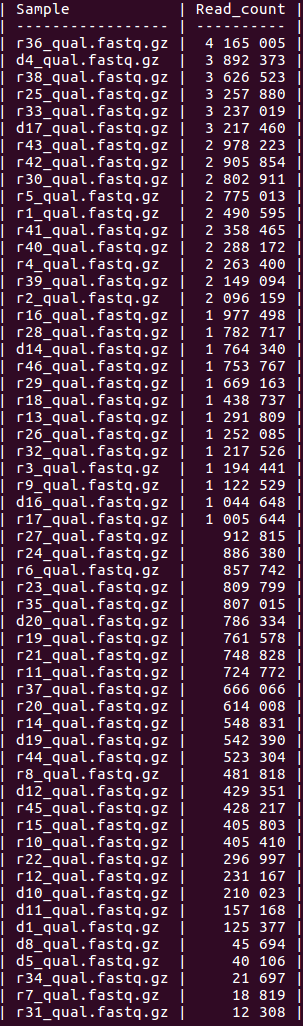

In [3]:
### CODE ###
display < ./Picture/read_count_qual.png;

*Ps* : We should have 66 samples (20 D, 46 R), but 5 of them (D2, D6, D7, D9 & D18) have no sequenced reads. <br>
Thus at this stage, we have 61.fastq.gz files for the remaining 61 samples.

### 3.3) Human reads removal

#### 3.3.1) Load data on genotoul :

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Output;
sudo scp -r Reads_qual escaon@genotoul.toulouse.inra.fr:/home/escaon/save/TTV;

##### Using BWA-0.7.15 to map reads on the human genome.

#### 3.3.2) Build BWA index :

Content of bwa_idx.sh :

In [ ]:
### CODE ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=48G
#$ -l h_vmem=60G
#$ -N GRCh38_bwa_idx
#$ -o /home/escaon/work/TTV/bwa_idx_o.txt
#$ -e /home/escaon/work/TTV/bwa_idx_e.txt

BWA='/usr/local/bioinfo/src/bwa/bwa-0.7.15/bwa';
path='/home/escaon/save/TTV/Data';

$BWA index -p GRCh38_p11_bwtsw -a bwtsw $path/GCA_000001405.26_GRCh38.p11_genomic.fna;

#### 3.3.3) Map reads :

Content of bwa_mem.sh (keep only unmapped) :

In [ ]:
### CODE ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=8G
#$ -l h_vmem=12G
#$ -N TTV_bwa_mem
#$ -o /home/escaon/work/TTV/ttv_bwa_mem_20170907_o.txt
#$ -e /home/escaon/work/TTV/ttv_bwa_mem_20170907_e.txt

# qsub -pe parallel_smp 8 bwa_mem.sh

BWA='/usr/local/bioinfo/src/bwa/bwa-0.7.15/bwa';
save='/home/escaon/save/TTV';
work='/home/escaon/work/TTV';
nt=8;

mkdir -p $work/Reads_qual_hm;
cd $save/Reads_qual;
for f in *.fastq.gz;
do $BWA mem -t $nt \
            -R '@RG\tID:'${f%%.*}'\tLB:'${f%%.*}'\tPL:IONTORRENT\tPU:GenoLim\tSM:'${f%%.*} \
            $work/Bwa_idx/GRCh38_p11_bwtsw \
            <(unpigz -c $f) |\
            samtools view -bh -f 4 \
            > $work/Reads_qual_hm/${f%%.*}.bam;
done;

#### 3.3.4) Validate BAMs :

Content of picard_validate.sh :

In [ ]:
### CODE ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=32G
#$ -l h_vmem=40G
#$ -N TTV_picard_validate
#$ -o /home/escaon/work/TTV/ttv_picard_val_o.txt
#$ -e /home/escaon/work/TTV/ttv_picard_val_e.txt

work='/home/escaon/work/TTV';
module load bioinfo/Java8;
PICARD='/usr/local/bioinfo/src/picard-tools/picard-tools-2.1.1/picard.jar';

cd $work/Reads_qual_hm;
for f in *.bam;
do echo $f; java -jar $PICARD ValidateSamFile I=$f MODE=SUMMARY;
done;

#### 3.3.5) Sort & index BAMs :

Content of samtools_sort_idx.sh :

In [ ]:
### CODE ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=40G
#$ -l h_vmem=48G
#$ -N TTV_samtools_sort_idx
#$ -o /home/escaon/work/TTV/ttv_samtools_sortidx_o.txt
#$ -e /home/escaon/work/TTV/ttv_samtools_sortidx_e.txt

work='/home/escaon/work/TTV';

cd $work/Reads_qual_hm;
for f in *.bam;
do samtools sort -o ${f%.*}"_sorted.bam" $f;
done;
for f in *_sorted.bam;
do samtools index $f;
done;

#### 3.3.6) BAM to FASTA :

Content of samtools_fasta.sh :

In [ ]:
### CODE ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=32G
#$ -l h_vmem=40G
#$ -N TTV_samtools_fasta
#$ -o /home/escaon/work/TTV/ttv_samtools_fasta_o.txt
#$ -e /home/escaon/work/TTV/ttv_samtools_fasta_e.txt

work='/home/escaon/work/TTV';

cd $work/Reads_qual_hm;
for f in *_sorted.bam;
do samtools fasta $f > ${f%_*}.fasta;
done;

#### 3.3.7) DL these FASTA files locally :

In [ ]:
### CODE ###
sudo scp escaon@genotoul.toulouse.inra.fr:/home/escaon/work/TTV/Reads_qual_hm/*.fasta \
         /home/erwann/Desktop/TTV/BISCEm/Output/Reads_qual_hm;

Number of reads in filtered files (*Ps* : Could have been checked in BAM (samtools view -c toto.bam)) : <br>

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Output/Reads_qual_hm;
for f in *.fasta;
do printf $f'\t';
   grep -c '^>' $f;
done;

### 3.4) 5' UTR reads removal

Rappel de l'objectif ici : Sachant que les génotypes de TTV partagent une zone en 5' qui est fortement conservée, il serait bon de ne pas tenir compte des reads qui s'alignent pour une majeur partie de leur longueur sur cette zone 5', pour éviter de créer des biais au niveau du compte des reads assignés à chaque génotype (en gros on préfère se focaliser sur les reads vraiment discriminants).

Ok, donc je pars sur ce consensus +++ conservé de 93nts. Cf : /home/erwann/Desktop/TTV/BISCEm/Data/TTV/Genomes_MSA/MultAlin result.html

*Nb* : En 3' de ce consensus, on retrouve directement pas mal de variabilité entre les génotypes. C'est moins vrai en 5', je dirais que les 67 nts en amont du consensus sont relativement conservés, donc pas forcément très discriminants pour nos objectifs.

Je pense donc appliquer la logique suivante :
Pour chaque jeu de données après filtre sur la qualité et soustraction des reads humain, aligner les reads restants contre le consensus de 93 nts.
Si un read possède un hit de 25 ou plus nts dans cette zone de 93nts alors :
Si ce read possède, en 3' du consensus, 50 ou plus nts non-impliqués dans le hit , on le conserve (car ces 50+ nts seront discriminants).
Si ce read possède, en 5' du consensus + 67 nts (pour tenir compte de la partie environ conservée), 50 ou plus nts non-impliqués dans le hit, on le conserve (car ces 50+ nts seront discriminants).
Si le read n'a pas assez de nts discriminants en 3' ou en 5' du consensus, alors il sera retiré du jeu de données.

Content of discard_5prime_consensus_reads.py :

In [ ]:
### CODE ###
#!/usr/bin/env python
import os
import sys

usage = '\t --------\n' \
        '\t| usage  : python discard_5prime_consensus_reads file_1\n' \
        '\t| input  : file_1 = blastn_vs_5prime_consensus.tsv\n' \
        '\t| output : a file containing read names to discard\n' \
        '\t --------'

if len(sys.argv) != 2:
    print(usage)
    sys.exit()

query_dic = {}
with open(sys.argv[1], 'r') as tsv:
    for row in tsv:
        columns = row.split('\t')
        qseqid, length, qstart, qend, sstart, send, qlen, sstrand = columns[0], int(columns[3]), int(
            columns[6]), int(columns[7]), int(columns[8]), int(columns[9]), int(columns[12]), columns[14].rstrip()
        if not qseqid in query_dic:
            if length >= 25:
                if sstrand == 'plus':
                    five_prime_overhead = (qstart - 1) - (sstart - 1) - 67
                    three_prime_overhead = (qlen - qend) - (93 - send)
                elif sstrand == 'minus':
                    five_prime_overhead = (qlen - qend) - (send - 1) - 67
                    three_prime_overhead = (qstart - 1) - (93 - sstart)
                else:
                    print('------------ERROR------------')
                if five_prime_overhead >= 50 or three_prime_overhead >= 50:
                    query_dic[qseqid] = 'keep'
                else:
                    query_dic[qseqid] = 'discard'

file = sys.argv[1].split('/')
sample = file[-1].split('.')[0]

with open(sample + '.discard', 'a') as out:
    for k, v in query_dic.items():
        if v == 'discard':
            out.write(k + "\n")

Apply this filtering step :

In [ ]:
### CODE ###
biscem='/home/erwann/Desktop/TTV/BISCEm';
blast='/home/erwann/Software/Ncbi_blast_2.6.0+/bin';
mkdir -p $biscem/Output/Reads_qual_hm_fivep;
cd $biscem/Output/Reads_qual_hm;
for f in *.fasta;
do $blast/blastn -subject $biscem/Data/TTV/ttv_5prime_consensus.fasta \
                 -query $f \
                 -reward 1 \
                 -penalty -3 \
                 -word_size 12 \
                 -gapopen 5 \
                 -gapextend 2 \
                 -evalue 0.0001 \
                 -dust "no" \
                 -perc_identity 90 \
                 -culling_limit 2 \
                 -out ${f%.*}.tsv \
                 -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart \
                          qend sstart send evalue bitscore qlen nident sstrand";
                 python $biscem/Scripts/discard_5prime_consensus_reads.py ${f%.*}.tsv;
                 grep '^>' $f | sort > ${f%.*}.headers; sed -i 's/^>//g' ${f%.*}.headers;
                 sort ${f%.*}.discard -o ${f%.*}.discard;
                 comm -23 ${f%.*}.headers ${f%.*}.discard > ${f%.*}.keepers;
                 seqtk subseq $f ${f%.*}.keepers > $biscem/Output/Reads_qual_hm_fivep/$f;
done;
rm *.tsv *.headers *.discard *.keepers;

Number of reads in filtered files :

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Output/Reads_qual_hm_fivep;
for f in *.fasta;
do printf $f'\t';
   grep -c '^>' $f;
done;

Upload them on genotoul & CALI :

In [ ]:
### CODE ###
sudo scp -r /home/erwann/Desktop/TTV/BISCEm/Output/Reads_qual_hm_fivep \
            escaon@genotoul.toulouse.inra.fr:/home/escaon/save/TTV;
sudo scp -r /home/erwann/Desktop/TTV/BISCEm/Output/Reads_qual_hm_fivep \
            scaonp01@cali.unilim.fr://home/scaonp01/TTV;

## 4) TTV taxonomical analysis

It was decided to focus on Orf1 for this analysis, based on 65% homology (Maggi, etc...)

### 4.1) Retrieve Orf1 sequences for our 57 genotypes

##### Manual inspection of the 57 genotypes entries for orf1 :

In [ ]:
### CODE ###
# Open NCBI accession webpage for all TTV genotypes
cd /home/erwann/Desktop/TTV/BISCEm/Data/TTV;
while read line;
do chromium-browser https://www.ncbi.nlm.nih.gov/nuccore/$line;
done < an_all_ttv_genotypes.txt;
# Create an empty BED file to store the infos that we are going to retrieve manually :-(
cd /home/erwann/Desktop/TTV/BISCEm/Data/TTV;
while read line;
do touch ../../Orf1/$line.bed;
done < an_all_ttv_genotypes.txt;
# Then fill the 57 BED files manually based on webpage info (start pos -1 plz) e.g. AB038621.1.bed => AB038621.1 665 2867
# The entries listed below have no annotated CDS for Orf1 :
# AX025718.1, AX025830.1, AX174942.1, KP343839.1 and NC_015783.1
# For them, go to https://www.ebi.ac.uk/Tools/psa/genewise/ & align this Orf1 protein sequence against them (https://www.ncbi.nlm.nih.gov/nuccore/NC_002076.2). They all have a hit <=> orf1, thus put this info in their BED
# Then use seqtk to retrieve Orf1 sequences based on BEDs
cd /home/erwann/Desktop/TTV/BISCEm/Data/TTV/All_ttv_genotypes_one_per_fasta;
for f in *.fasta;
do seqtk subseq $f ../Orf1/${f%.*}.bed > ../Orf1/${f%.*}.fasta;
done;
# Check that our resulting Orf1 seqs len are / by 3
cd ../Orf1;
for f in *.fasta;
do printf $f" : "; grep -v ">" $f \
   | wc \
   | awk '{print ($3-$1)/3}';
done;

### 4.2) Create taxo groups based on Orf1 homology

Voici les résultats de la phylogénie orf1 (alignement mafft+rooted UPGMA tree). <br>
En comptant 65% de similitude on part sur 30 groupes : *cf* groupes-pim.html (percentage identity matrix) et figure ci-dessous :

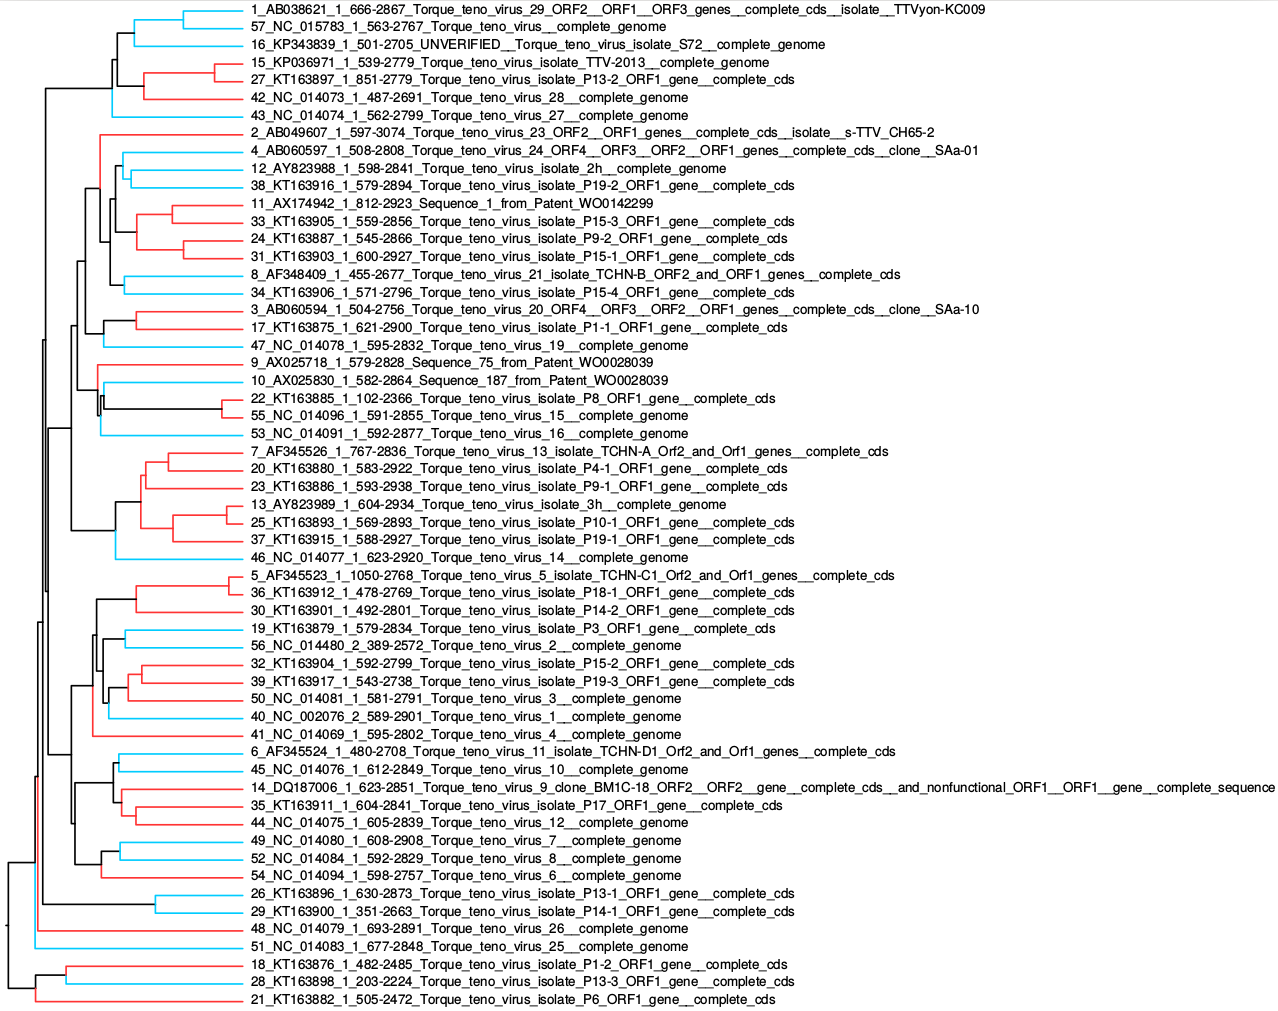

In [4]:
### CODE ###
display < ./Picture/taxo_tree.png;

## 5 Assign reads to microbial DBs & TTV genotypes

##### blast 2.6.0+

Fungal & bacterial blastn output needs (definie outfmt 6 fields) : <br>
qlen # Query sequence length (needed to filter hits shorter than 90% of qlen) <br>
saccver # Subject accession.version (in case of future need for eutils => access to taxo infos) <br>
Which translate into : -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen"

Viral blastn output needs : <br>
We need additional outfmt 6 fields to parse for Orf1 : <br>
qstart # Start of alignment in query <br>
qend # End of alignment in query <br>
slen # Subject sequence length <br>
sstart # Start of alignment in subject <br>
send # End of alignment in subject <br>
sstrand # Subject Strand <br>
Which translate into : -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen qstart qend slen sstart send sstrand"

### 5.1) Create databases

#### 5.1.1) Viral DBs

In [ ]:
### CODE ###
# Check intersection between viral_rr & our_57_ttv_genotypes
data='/home/erwann/Desktop/TTV/BISCEm/Data';
cd $data/Viral;
sort -u -o ids_ncbi_refseq_release_viral.txt ids_ncbi_refseq_release_viral.txt;
cd $data/TTV;
sort -u -o an_all_ttv_genotypes.txt an_all_ttv_genotypes.txt;
comm an_all_ttv_genotypes.txt $data/Viral/ids_ncbi_refseq_release_viral.txt > ttvG_vs_viralRefSeq_intersection.tsv;

cd $data/TTV;
zgrep -i 'complete genome' all_ttv_genotypes.fasta.gz > complete_genomes.txt;
sed -i 's/>//g' complete_genomes.txt;
awk -F ' ' '{print $1}' complete_genomes.txt > an_complete_genomes.txt;
rm complete_genomes.txt;

# All "NC" genomes (18) amongst our 57 ttv genotypes are complete genomes and are present in viral_rr. We have 4 additional genomes labeled as complete amongst our 57, which are : KP343839.1, KP036971.1, AY823989.1 & AY823988.1.
# Let's add them to viral_rr to create future rr_viral_plus_complete_genome (create a file call add_those_seq_to_refseq.txt containing those 4 an).

seqtk subseq all_ttv_genotypes.fasta.gz add_those_seq_to_refseq.txt> add_those_complete_genome_to_rr.fasta;
pigz add_those_complete_genome_to_rr.fasta;
cat add_those_complete_genome_to_rr.fasta.gz $data/Viral/ncbi_refseq_release_viral.fna.gz > ncbi_refseq_release_viral_plus_ttv_complete_genomes.fasta.gz;

blast='/home/erwann/Software/Ncbi_blast_2.6.0+/bin/';
unpigz ncbi_refseq_release_viral_plus_ttv_complete_genomes.fasta.gz;
$blast/makeblastdb -in ncbi_refseq_release_viral_plus_ttv_complete_genomes.fasta -input_type fasta -dbtype nucl -out $data/Blast_DB/rr_viral_plus_complete_genome;
pigz ncbi_refseq_release_viral_plus_ttv_complete_genomes.fasta;

Ps : Discuter et faire ici ajustement DB viral // TTV et aux seqs Orf1 et g_complet => OUI.

#### 5.1.2) Fungal DB

In [ ]:
### CODE ###
c ~/Desktop/TTV/BISCEm/Data/Fungal;
BLAST='/home/erwann/Desktop/ncbi-blast-2.6.0+/bin';
unpigz ncbi_refseq_release_fungi.fna.gz;
$BLAST/makeblastdb -in ncbi_refseq_release_fungi.fna -input_type fasta -dbtype nucl -out rr_fungi;
pigz ncbi_refseq_release_fungi.fna;

#### 5.1.3) Bacterial DB

In [ ]:
### CODE ###
blast='/home/erwann/Software/Ncbi_blast_2.6.0+/bin';
unpigz hmp_bacterial.fasta.gz;
$blast/makeblastdb -in hmp_bacterial.fasta -input_type fasta -dbtype nucl -out hmp_bacterial;
pigz hmp_bacterial.fasta;

### 5.2) Blastn vs viral DBs

Done locally :

In [ ]:
### CODE ###
# Versus rr_viral_plus_ttv
biscem='/home/erwann/Desktop/TTV/BISCEm';
blast='/home/erwann/Software/Ncbi_blast_2.6.0+/bin';
mkdir -p $biscem/Output/Viral_blastn;
nt=8;

cd $biscem/Output/Reads_qual_hm_fivep;
for f in *.fasta;
do $blast/blastn -db $biscem/Data/Blast_DB/rr_viral_plus_ttv \
                 -query $f \
                 -reward 1 \
                 -penalty -3 \
                 -word_size 12 \
                 -gapopen 5 \
                 -gapextend 2 \
                 -evalue 0.0001 \
                 -dust "no" \
                 -perc_identity 90 \
                 -culling_limit 2 \
                 -out $biscem/Output/Viral_blastn/${f%_*}"_vs_viral.tsv" \
                 -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart \
                          qend sstart send evalue bitscore qlen slen sstrand" \
                 -num_threads $nt;
done;

# Versus rr_viral_plus_complete_genome
biscem='/home/erwann/Desktop/TTV/BISCEm';
blast='/home/erwann/Software/Ncbi_blast_2.6.0+/bin';
mkdir -p $biscem/Output/Viral_blastn_complete;
nt=8;

cd $biscem/Output/Reads_qual_hm_fivep;
for f in *.fasta;
do $blast/blastn -db $biscem/Data/Blast_DB/rr_viral_plus_complete_genome \
                 -query $f \
                 -reward 1 \
                 -penalty -3 \
                 -word_size 12 \
                 -gapopen 5 \
                 -gapextend 2 \
                 -evalue 0.0001 \
                 -dust "no" \
                 -perc_identity 90 \
                 -culling_limit 2 \
                 -out $biscem/Output/Viral_blastn_complete/${f%_*}"_vs_viral.tsv" \
                 -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart \
                          qend sstart send evalue bitscore qlen slen sstrand" \
                 -num_threads $nt;
done;

### 5.3) Blastn vs fungal DB

Done on CALI :

Create an initial script :

In [ ]:
### CODE ###
#!/bin/bash
#SBATCH --partition=normal
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=12
#SBATCH --mem-per-cpu=8192
#SBATCH --time=1-23:59:59
#SBATCH --mail-user=erwan.scaon@unilim.fr
#SBATCH --mail-type=begin
#SBATCH --mail-type=end
#SBATCH --error=/home/scaonp01/scratch/TTV/ttv_blastn_fungal_d5.verbose
#SBATCH --output=/home/scaonp01/scratch/TTV/ttv_blastn_fungal_d5.verbose
#SBATCH --job-name=ttv_blastn_fungal_d5

# sbatch blastn_fungal_d5.sh

##############################
### Paths, tools & modules ###
##############################
nt=12;
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK;
ttv='/home/scaonp01/TTV';
scratch='/home/scaonp01/scratch/TTV';
blast='/home/scaonp01/Softwares/Ncbi_blast_plus_2.6.0';

################
### Commands ###
################
cd $ttv/Reads_qual_hm_fivep;
for f in d5_qual.fasta;
do $blast/blastn -db $ttv/DB/rr_fungi \
                 -query $f \
                 -reward 1 \
                 -penalty -3 \
                 -word_size 12 \
                 -gapopen 5 \
                 -gapextend 2 \
                 -evalue 0.0001 \
                 -dust "no" \
                 -perc_identity 90 \
                 -culling_limit 2 \
                 -out $scratch/${f%_*}"_vs_fungal.tsv" \
                 -outfmt "6 qseqid sseqid pident length mismatch gapopen \
                          qstart qend sstart send evalue bitscore qlen" \
                 -num_threads $nt;
done;

Launch script :

In [ ]:
### CODE ###
sbatch blastn_fungal_d5.sh;

Duplicate it for the other samples :

In [ ]:
### CODE ###
# Check what we are going to replace
for id in 'd5';
do grep --color -i $id blastn_fungal_"$id".sh;
done;

# Dup scripts
for id in 'd1' 'd3' 'd4' 'd8' 'd10' 'd11' 'd12' 'd13' 'd14' 'd15' 'd16' 'd17' \
          'd19' 'd20' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8' 'r9' 'r10' 'r11' \
          'r12' 'r13' 'r14' 'r15' 'r16' 'r17' 'r18' 'r19' 'r20' 'r21' 'r22' 'r23' \
          'r24' 'r25' 'r26' 'r27' 'r28' 'r29' 'r30' 'r31' 'r32' 'r33' 'r34' 'r35' \
          'r36' 'r37' 'r38' 'r39' 'r40' 'r41' 'r42' 'r43' 'r44' 'r45' 'r46';
do cp blastn_fungal_d5.sh blastn_fungal_"$id".sh;
done;

# Replace with new E name
for id in 'd1' 'd3' 'd4' 'd8' 'd10' 'd11' 'd12' 'd13' 'd14' 'd15' 'd16' 'd17' \
          'd19' 'd20' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8' 'r9' 'r10' 'r11' \
          'r12' 'r13' 'r14' 'r15' 'r16' 'r17' 'r18' 'r19' 'r20' 'r21' 'r22' 'r23' \
          'r24' 'r25' 'r26' 'r27' 'r28' 'r29' 'r30' 'r31' 'r32' 'r33' 'r34' 'r35' \
          'r36' 'r37' 'r38' 'r39' 'r40' 'r41' 'r42' 'r43' 'r44' 'r45' 'r46';
do sed -i "s/d5/$id/" blastn_fungal_"$id".sh;
done;

# Launch
for id in 'd1' 'd3' 'd4' 'd8' 'd10' 'd11' 'd12' 'd13' 'd14' 'd15' 'd16' 'd17' \
          'd19' 'd20' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8' 'r9' 'r10' 'r11' \
          'r12' 'r13' 'r14' 'r15' 'r16' 'r17' 'r18' 'r19' 'r20' 'r21' 'r22' 'r23' \
          'r24' 'r25' 'r26' 'r27' 'r28' 'r29' 'r30' 'r31' 'r32' 'r33' 'r34' 'r35' \
          'r36' 'r37' 'r38' 'r39' 'r40' 'r41' 'r42' 'r43' 'r44' 'r45' 'r46';
do sbatch blastn_fungal_"$id".sh;
done;

### 5.4) Blastn vs bacterial DB

Done on Genotoul :

Create an initial script (blastn_bacterial_d5.sh) :

In [ ]:
### Code ###
#!/bin/bash
#$ -q workq
#$ -M erwan.scaon@unilim.fr
#$ -m bea
#$ -l mem=8G
#$ -l h_vmem=10G
#$ -N TTV_blastn_bacterial_d5
#$ -o /home/escaon/work/TTV/ttv_blastn_bacterial_d5_o.txt
#$ -e /home/escaon/work/TTV/ttv_blastn_bacterial_d5_e.txt

# qsub -pe parallel_smp $nt script.sh

work='/home/escaon/work/TTV';
save='/home/escaon/save/TTV';
blast="$work/NCBI_BlastPlus_2.6.0/bin";
mkdir -p $work/Bacterial_blastn;
nt=8;

cd $save/Reads_qual_hm_fivep;
for f in d5_qual.fasta;
do $blast/blastn -db $work/Blast_db/hmp_bacterial \
                 -query $f \
                 -reward 1 \
                 -penalty -3 \
                 -word_size 12 \
                 -gapopen 5 \
                 -gapextend 2 \
                 -evalue 0.0001 \
                 -dust "no" \
                 -perc_identity 90 \
                 -culling_limit 2 \
                 -out $work/Bacterial_blastn/${f%_*}"_vs_bacterial.tsv" \
                 -outfmt "6 qseqid sseqid pident length mismatch gapopen \
                          qstart qend sstart send evalue bitscore qlen" \
                 -num_threads $nt;
done;

Launch it :

In [ ]:
### CODE ###
qsub -pe parallel_smp 8 blastn_bacterial_d5.sh;

Duplicate it for the other samples :

In [ ]:
#### Code ###
# Check what we are going to replace
for id in 'd5';
do grep --color -i $id blastn_bacterial_"$id".sh;
done;

# Dup scripts
for id in 'd1' 'd3' 'd4' 'd8' 'd10' 'd11' 'd12' 'd13' 'd14' 'd15' 'd16' 'd17' \
          'd19' 'd20' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8' 'r9' 'r10' 'r11' \
          'r12' 'r13' 'r14' 'r15' 'r16' 'r17' 'r18' 'r19' 'r20' 'r21' 'r22' 'r23' \
          'r24' 'r25' 'r26' 'r27' 'r28' 'r29' 'r30' 'r31' 'r32' 'r33' 'r34' 'r35' \
          'r36' 'r37' 'r38' 'r39' 'r40' 'r41' 'r42' 'r43' 'r44' 'r45' 'r46';
do cp blastn_bacterial_d5.sh blastn_bacterial_"$id".sh;
done;

# Replace with new E name
for id in 'd1' 'd3' 'd4' 'd8' 'd10' 'd11' 'd12' 'd13' 'd14' 'd15' 'd16' 'd17' \
          'd19' 'd20' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8' 'r9' 'r10' 'r11' \
          'r12' 'r13' 'r14' 'r15' 'r16' 'r17' 'r18' 'r19' 'r20' 'r21' 'r22' 'r23' \
          'r24' 'r25' 'r26' 'r27' 'r28' 'r29' 'r30' 'r31' 'r32' 'r33' 'r34' 'r35' \
          'r36' 'r37' 'r38' 'r39' 'r40' 'r41' 'r42' 'r43' 'r44' 'r45' 'r46';
do sed -i "s/d5/$id/" blastn_bacterial_"$id".sh;
done;

# Launch
for id in 'd1' 'd3' 'd4' 'd8' 'd10' 'd11' 'd12' 'd13' 'd14' 'd15' 'd16' 'd17' \
          'd19' 'd20' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8' 'r9' 'r10' 'r11' \
          'r12' 'r13' 'r14' 'r15' 'r16' 'r17' 'r18' 'r19' 'r20' 'r21' 'r22' 'r23' \
          'r24' 'r25' 'r26' 'r27' 'r28' 'r29' 'r30' 'r31' 'r32' 'r33' 'r34' 'r35' \
          'r36' 'r37' 'r38' 'r39' 'r40' 'r41' 'r42' 'r43' 'r44' 'r45' 'r46';
do qsub -pe parallel_smp 8 blastn_bacterial_"$id".sh;
done;

### 5.5) Hit count for DBs

##### Viral DB :

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Output/Viral_blastn;
# Discard blastn hits shorter than 90% of query(read)_len
for f in *.tsv;
do awk -F "\t" '$4>=($13*90/100) {print $0}' $f \
       > ${f%%_*}"_vs_viral_threshed.tsv";
done;
# Print unique reads ids (rid) with at least 1 hit in each TSV
for f in *_threshed.tsv;
do printf $f"\t";
   awk '{print $1}' $f \
       | sort -u \
       | wc -l;
done;

##### Per TTV genotypes Orf1 inside Viral DB :

In [ ]:
### CODE ###
for f in *_threshed.tsv
python ./counts_orf1.py 

##### Fungal :

##### Bacterial :

Retrieve blastn results from genotoul :

In [ ]:
### CODE ###
# some verifications first
grep -i error *.txt # OK
l -1 Bacterial_blastn/*.tsv | wc -l # 61
# & check that all mails have "Exit Status = 0"
# => OK

# DL locally
sudo scp -r escaon@genotoul.toulouse.inra.fr:/home/escaon/work/TTV/Bacterial_blastn \
/home/erwann/Desktop/TTV/BISCEm/Output;

Get number of uniques reads matching bacterial DB :

In [ ]:
### CODE ###
cd ~/Desktop/TTV/BISCEm/Output/Bacterial_blastn;

# Discard blastn hits shorter than 90% of query(read)_len
for f in *.tsv;
do awk -F "\t" '$4>=($13*90/100) {print $0}' $f \
       > ${f%%_*}"_vs_bacterial_threshed.tsv";
done;

# Retrieve unique reads ids (rid) with at least 1 hit in each TSV
for f in *_threshed.tsv;
do awk '{print $1}' $f \
       | sort -u \
       > ${f%%_*}_threshed_rid.txt;
done;
wc -l *.txt;

### 5.6) Hit count per TTV genotypes

In [ ]:
### CODE ###
# Orf1
cd ~/Desktop/TTV/BISCEm/Output/Viral_blastn;
for f in *_threshed.tsv;
do mkdir -p ${f%%_*};
   cd ${f%%_*};
   python ../../../Scripts/counts_orf1.py ../$f;
   cd ..;
done;

# Complete
cd ~/Desktop/TTV/BISCEm/Output/Viral_blastn_complete;
for f in *_threshed.tsv;
do python ../../Scripts/counts_per_g_complete.py $f;
done;